# Health Information Systems and Decision Support Systems
## WPO 3: Data-driven systems 1: Regression  (01/03/24)
***
*Jakub Ceranka, Joris Wuts, Jef Vandemeulebroucke* <br>
*Department of Electronics and Informatics (ETRO)* <br>
*Vrije Universiteit Brussel, Pleinlaan 2, B-1050 Brussels, Belgium*

<font color=blue>Insert students names and IDs here</font>

***
### Goal
The goal of this practical session is to get an insight into logistic regression modelling using real life medical data from patients infected with COVID-19. Your tasks will involve building different models to predict disease severity and analyze the relations between different variables and severity risk. Students must send their notebook using the Assignment functionality in Canvas before the __7th of March, 2023, 23:59. Remember to include the HTML format!__ The grade from this practical session will contribute to your final grade.
Questions: on the discusion channel on canvas
***
In this practical session you will predict the severity of the COVID-19 outcome, based on the analysis of patient information and the corresponding computed tomography (CT) images features of COVID-19 suspects and actual patients suffering from COVID-19.
***
#### COVID features dataset
Have a look at the provided COVID datasheet (*COVID_data.csv*) with multiple features describing various COVID patients and suspects. The dataset consist of 2000 data points with multiple features, each datapoint representing an actual COVID-patient or a COVID-suspect.

The contents of the feaures provide the following information:
*   *PatientID*: ID of the patient
*   *Age*: Age of the patient categorized into one of 6 categories to limit the risk of deanonimization.
*   *Sex*: M or F - patient gender
*   *Covid*: Indicates whether the patient had a confirmed COVID infection
*   *Severity*: For COVID patients, indicates whether the disease was severe (need for intubation or caused patient death)
*   *Image_size* and *Spacing* are CT image parameters used for imaging
*   *GGO*: Proportion of the lung with GGO. Ground glass opacity (*GGO*) refers to the hazy gray areas that can show up in CT scans or X-rays of the lungs. These gray areas indicate increased density inside the lungs. The term comes from a technique in glassmaking during which the surface of the glass is blasted by sand.
*   *Consolidation*: Proportion of the lung with consolidated lessions. A pulmonary consolidation is a region of normally compressible lung tissue that has filled with liquid instead of air.

Two last features (*GGO* and *Consolidation*) were extracted from CT images of patients with COVID, or suspects of having COVID, and the ratio to the total lung volume is provided.

<img src="GGO.jpeg" alt="Drawing" style="width: 600px;"/>

High-resolution CT image showing ground-glass opacities in the periphery of both lungs in a patient with COVID-19 (red arrows). The adjacent normal lung tissue with lower attenuation appears as darker areas.


### Importing packages

During this lab session you will need a couple of packages, run the following cell to import pandas, numpy, seaborn and matplotlib.

In [ ]:
%pip install statkit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

***
## Part 1: Loading, cleaning and analyzing the data
### Task 1.1 Loading and cleaning the data
Lets read the data into the dataframe `data`.

Inspect the dataframe and drop the following columns : `Images_sizes, Spacings, PatientID`.

Your processed dataframe should have a shape of `(2000,6)`.

Please call your final dataframe `df` throughout the whole lab session, as we provide code snipets in Task 2 and 3 that assume this variable name for the dataframe.

To further use the dataframe, we need to binarize the `Sex` label. Binarize the column so that male patients have a value of 1 and females of 0. Finally, filter the dataframe so it only has COVID positive patients. After filtering you can also drop the COVID column.

Your final dataframe should be a shape of `(1205, 5)`.

In [21]:
df = pd.read_csv('COVID_data.csv')
df.drop(df.loc[:, df.columns.str.contains('Image_size')], axis=1, inplace=True)
df.drop(df.loc[:, df.columns.str.contains('Spacing')], axis=1, inplace=True)
df.drop('PatientID', axis=1, inplace=True)

print(f"\ndf shape: {df.shape}")
df.head()


df shape: (2000, 6)


,Age,Sex,Covid,Severity,GGO,Consolidation
0,65,M,1,0,0.097123,0.049944
1,35,F,0,0,0.084260,0.009885
2,65,M,0,0,0.187388,0.011108
3,85,M,0,0,0.102844,0.017063
4,65,F,0,0,0.001064,0.001452


***
### Task 1.2: Assess the severity of COVID-19 in function of age

Plot a histogram for the different age groups. Note, that the ages are categorical at 6 fixed values.

__Hint:__ Use seaborns `histplot`.

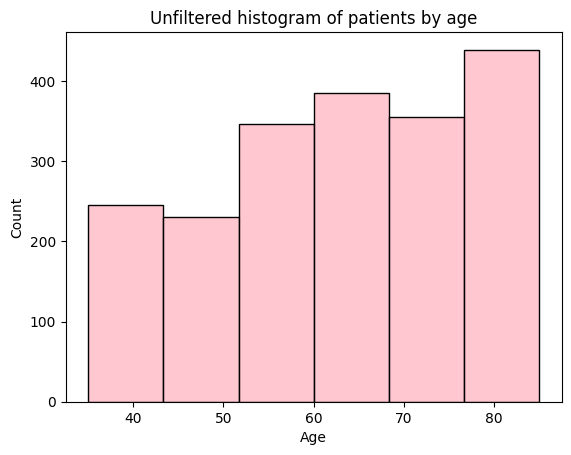

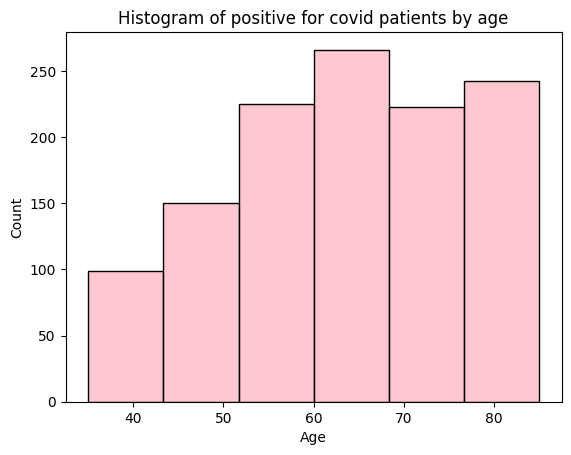

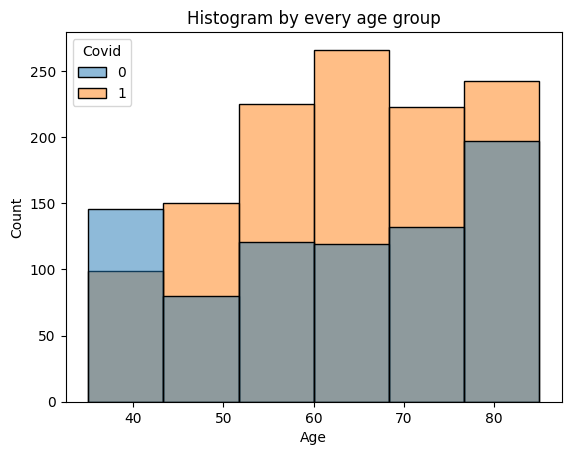

In [31]:
# with both positive and negative covid 
sns.histplot(data=df, x='Age', color='lightpink', bins=6) 
plt.title("Unfiltered histogram of patients by age")
plt.show()

# positive for covid result
sns.histplot(data=df[df['Covid']==1], x='Age', color='lightpink', bins=6) 
plt.title("Histogram of positive for covid patients by age")
plt.show()

# histogram for every age group
sns.histplot(data=df, x='Age', hue='Covid', color='lightpink', bins=6) 
plt.title("Histogram by every age group")
plt.show()


### Question 1.1: What can you conclude from this plots?

Answer to question 1.1: ...

***
### Task 1.3: Checking the impact of GGO, consolidation and sex on the COVID severity

Now make similar two kde plots to assess the correlations between the `GGO`, `Consolidation` vs `Severity`.

To assess the impact of `sex`  we will use a different plot. Use a scatter plot to plot the mean fraction of severity per age group. Use 2 different colours for male and female patients.

__hint__: Split the dataframe into 2 new dataframes containing only 1 sex. Then use the groupby functionality to agregate information per age group.

In [ ]:
# GGO vs Severity plot

In [ ]:
# Consolidation vs Severity plot

In [ ]:
# Sex vs Severity plot

### Question 1.2: What can you say about the relations of `Consolidation`, `GGO` and `Sex` with the `Severity` of COVID?

Answer to Question 1.2: ...


***
## Part 2:  Logistic regression of severity on `Age` and `Gender`

Logistic regression allows us to analyze how a set of features affects some binary target label. The weights gives us an estimation of the influence of each particular feature on the probability of the target being equal to one.

We want to model how the probability that a person develops a severe COVID disease is affected by his/her age, sex, and size lung lesions.

Let $y_i = 1$ if i-th person's develop severe symptoms.
Logistic regression models this probabilty in the following way:

\begin{equation}
p(y_i = 1 \mid \beta) = \sigma (\alpha + \beta_0 age_i + \beta_1 sex_i + \dots ),
\end{equation}

where $\sigma(t) = \frac1{1 + e^{-t}}$

We can obtain a point estimate for the intercept $\alpha$ and coefficients $\beta_k$ using *sklearn* package.


### Task 2.1: Define the logistic function

To compute probabilities with the logistic regresion, we first need to define the logistic functions. Use `numpy` and complete the code function below so it returns the logistic function $\sigma(t) = \frac1{1 + e^{-t}}$.

Test your system. The `logistic(1)` should return a value of `+- 0.731`.

In [ ]:
def logistic(x):
    # Your code here

    return logit

### Task 2.2: Fit a logistic regresion model.
Now lets fit a logistic regression model for COVID severity. This first basic model will only consider two features. We thus have to create a feature set ```X``` by only selecting the ```age``` and ```sex``` columns of the total ```df```. Make sure that age is the first feature column during the whole lab session! Use the logistic regression model (with all default parameters) of ```scikit-learn``` to create and fit the model. Then, print the values of coefficients and the interception of the fitted model.

In [ ]:
# Your code here

### Question 2.1: What do the coefficients and interceptions mean ?

In [ ]:
# Your answer here

### Task 2.3: Computing severity risks with the obtained model
Now manually compute the probability of severity with the obtained coefficients. Use your own defined logistic function and the formula presented in task 2.1. Compare the probability of severe disease  of the following patients:
- 60y old male
- 50y old woman.
- 35y old male
- 40y old woman


__Hint__: Represent all features in one numpy array with shape 4 ( patients) by 2 (features). Can you re write the Formula given in task 2 as a Matrix multiplication? A matrix multiplicatoin can be performed by the '@' operation on numpy arrays, Transprosing matrixes with '.T' can also be usefull!


In [ ]:
#Your Code here

### Task 2.4: Plotting severity curves
In task 1.3, you where asked to plot the mean severity for different ages per gender in a scatter plot. In task 2.3, you got probabilities of severity for specific age,sex combinations. Now print 2 curves representing the probability of having severe COVID per age for all ages between 20 and 100. On the same plot, also plot the results obtained from task 1.3.

__hint__: Manually define X

__hint__: Use np.linspace to contstruct an array of all possible ages between 20 and 100

__hint__: np.vstack can be usefull to concatenate 2 np arrays. You can use it to construct X

__hint__: Create an X matrix representing males, and a seperate X matrix for females. You can then easily plot them in different colours



In [ ]:
#Your code here

### Question 2.2: This function does not look like a standard sigmoid function, why ? What can you say about the relation between age, gender and severity?

In [ ]:
#Your answer here:

# Part 3: Confidence intervals

This model already gives us a trend on the impact of COVID severity. But how certain are we on the obtained results? The confidence intervals can be obtained using the method of bootstrapping. By fitting the model 1000 times on random subsets of the dataset, we can obtain 1000 sets of coefficients and interceptions of the model that we can later analyse. We estimate the parameter for many random samples of the population and obtain an approximation of the sampling distribution of the coefficient estimate. This method is very general, as it is independent of the estimator and makes fewer assumptions than other methods.





### Task 3.1: Obtain Bootstrap results:

Fit 1000 models on random subsets of the data with replacement. every dataset sample with give you 1 set of parameters.

__hint__: Use the pandas.sample function with replacement to draw a bootstrap sample with the same size as the original df
__hint2__: Make sure that you store the coeficients and the intercepts in the lists provided by us, later you will need them to plot the confidence intervals

In [ ]:
N_bs = 1000
coef_bs = np.zeros([2,N_bs])
int_bs = np.zeros([1,N_bs])


for i in range(N_bs):
  #YOur code here


### 3.2: Visualization and analysis of results

The code snippit below plots confidence intervals for a bootstrapped model, Use it together with your code in task 2.4 to plot confidence interval around the obtained curves from task 2.4.

In [ ]:
# This function plots confidence intervals for a set of bootstrapped intercepts and coeficients.
# You also have to provide the values on the x_axis,and a colour scheme
def plot_CI(int_bs,coef_bs,X,color):
    CI = np.percentile(logistic(int_bs.T + coef_bs.T @ X), [2.5, 97.5], axis=0)
    plt.fill_between(X[0], CI[0], CI[1], color=color, alpha=0.1)


In [ ]:
# Your code here:

### Question 3.1: What can you conclude from this graph. What does it mean that the confidence intervals don't overlap?


In [ ]:
# Answer to question 3.1: ...

***
## Part 4: Add `GGO` and `Consolidation`  

The previous model only explored the gender and age effect. In this part, we are going to add the `GGO` and `Consolidation` to the model.

### Task 4.1.

Similar to the code provided in Part 2, retrain the model on all 4 features. Print the coefficients and intercept.

In [ ]:
# Your code here

### Question 4.1: The shape of the coefficient vector has changed, what do the values represent? Based on these values, what feature do you expect to have the highest impact on disease severity?

In [ ]:
# Answer to question 3.1: ...

### Task 4.2: Use the bootstrapping technique to create the confidence interval for the new model

In [ ]:
# Your code here

In [ ]:
# Solution

N_bs = 1000
coef_bs_1 = np.zeros([4,N_bs])
int_bs_1 = np.zeros([1,N_bs])

for i in range(N_bs):
  #your code here

### Tasks 4.3: Visualize the results of ```consolidation``` and ```GGO```:
As we now have multi-dimensional and continous data, we have to apply some tricks to plot the results.
Firstly, to reduce the dimensionality, we will only focus on males.
Secondly, a logistic regression model is a linear model, we can simply average out features.

Furthermore, ```consolidation``` and ```GGO``` are continous values. To assess their full impact, we will use the 10th and 90th percentiles. This reflects a 'High' or 'Low' value of ```consolidation``` and ```GGO```

__Hint 1:__ Create X such that you only have males.

__Hint 2:__ Set the ```GGO``` value to its mean in ```X``` when inspecting the impact of ```consolidation``` and vise versa.

__Hint 3:__ To create 2 plots, use the 10th and 90th percentile values in ```X``` for the feature of interest. (with np.percenile)

__Hint 4:__ You do not need to have the pointplots here as we do not have cathegorical data for the ```GGO``` and ```consolidation```.


In [ ]:
# Code for impact of GGO

In [ ]:
# code for impact of Consolidation


### Question 4.2: What can you say on the impact on severity from `GGO` and `Consolidation`? Which one has the highest impact ?

In [ ]:
# Answer to Question 3.2: ...

In [ ]:
# Solution
#There is no additional risk increase due to consolodiation for age and GGO fixed.

#Effect of GGO on severity risk is large, approximately 50% increase for people of 60 years old.
# This is larger than the age effect, which is lower thatn 40% in the whole range of age.

### Question 4.3: Does this insight agrees with your answer to Q3.1? Why could this happen?
__Hint:__ Have a look at the density plots you made in Part 1.

In [ ]:
# Answer to Question 3.3: ...

## Part 5: Cost functions

After extracting knowledge from the data, it is time to put the logistic regression models into action.

You are working in an insurance company, and you have to advice the government what kind of financial model they should use to treat COVID-19 patients. The two options on the table are the logistic regression models trained on 2 (i.e. ```Age``` and ```Sex```) or on 4 features (i.e. ```Age```, ```Sex```, ```GGO```, ```Consolidation```).

Use decision curve analysis to investigate the 2 options.

__Hint 1:__ As you will now use the models to make predictions, it is nescacary to split your dataset in a train and test split. Use sklearn for this and use a test split of size 33%.

__Hint 2:__ First, train your logistic regression model on 2 and later on 4 features. Use ```sklearn``` function ```predict_proba()``` to get probability values for your ```X```.

__Hint 3:__ Use the ```NetBenefitDisplay``` function from the ```statkit``` package to plot the curves.



In [1]:
# Your code here

### Question 5.1: What model would you advice to use. Explain with the help of the curves

In [ ]:
# Your answer here...